# Flora MobileNet V3 Large Model Pretrained Weights

### 1. Import Libraries

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights


### 2. Load Dataset

In [2]:
data_dir = './dataset'  # Replace with the path to your dataset

### 3. Set Hyperparameters, Model, Loss Function, Optimizer

In [ ]:
batch_size = 16
num_epochs = 10
num_classes = 5  
model_path = '../../saved_models/flora/flora_model.pt'
onnx_path = '../../saved_models/flora/flora_model.onnx'

### 4. Data Transforms and Dataset Setup

In [4]:
weights = MobileNet_V3_Large_Weights.DEFAULT
transform = weights.transforms()

dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

class_names = dataset.classes
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 5. Load MobileNetV3 Model and Modify Final Layer

In [5]:
model = mobilenet_v3_large(weights=weights)

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to C:\Users\bhuva/.cache\torch\hub\checkpoints\mobilenet_v3_large-5c1a4163.pth
100.0%


### 6. Define Loss, Optimizer & Tracking Lists

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

### 7. Training and Validation Loop

In [7]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10, Train Loss: 0.4777, Train Acc: 0.8256, Val Loss: 0.4940, Val Acc: 0.8270
Epoch 2/10, Train Loss: 0.2941, Train Acc: 0.8893, Val Loss: 0.2694, Val Acc: 0.9019
Epoch 3/10, Train Loss: 0.2277, Train Acc: 0.9155, Val Loss: 0.2737, Val Acc: 0.9005
Epoch 4/10, Train Loss: 0.1816, Train Acc: 0.9346, Val Loss: 0.3030, Val Acc: 0.8965
Epoch 5/10, Train Loss: 0.1530, Train Acc: 0.9448, Val Loss: 0.2611, Val Acc: 0.9169
Epoch 6/10, Train Loss: 0.1106, Train Acc: 0.9629, Val Loss: 0.2741, Val Acc: 0.9142
Epoch 7/10, Train Loss: 0.1035, Train Acc: 0.9636, Val Loss: 0.2556, Val Acc: 0.9264
Epoch 8/10, Train Loss: 0.0953, Train Acc: 0.9663, Val Loss: 0.2701, Val Acc: 0.9196
Epoch 9/10, Train Loss: 0.0892, Train Acc: 0.9690, Val Loss: 0.2838, Val Acc: 0.9087
Epoch 10/10, Train Loss: 0.0852, Train Acc: 0.9683, Val Loss: 0.2896, Val Acc: 0.9155


### 8. Visualize Training Metrics

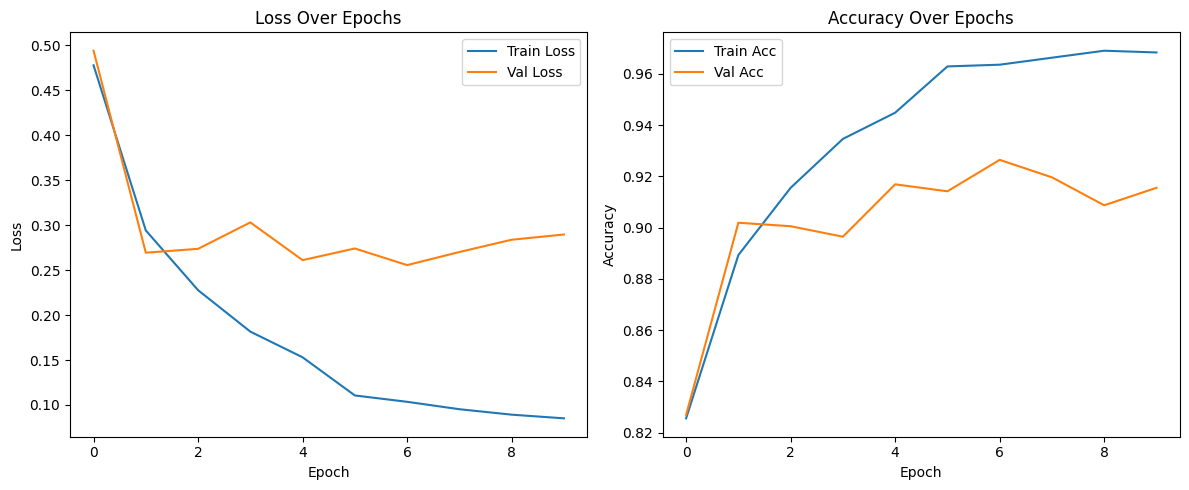

In [8]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### 9. Save Model and Export to ONNX

In [10]:
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# Export to TorchScript
scripted_model = torch.jit.script(model)
tscript_path = '../../saved_models/flora/flora_model_scripted.pt'
torch.jit.save(scripted_model, tscript_path)
print(f"✅ TorchScript model saved to: {tscript_path}")

✅ Model saved to: ../../saved_models/flora/flora_model.pt
✅ TorchScript model saved to: ../../saved_models/flora/flora_model_scripted.pt


### 10. Test Model on Single Image

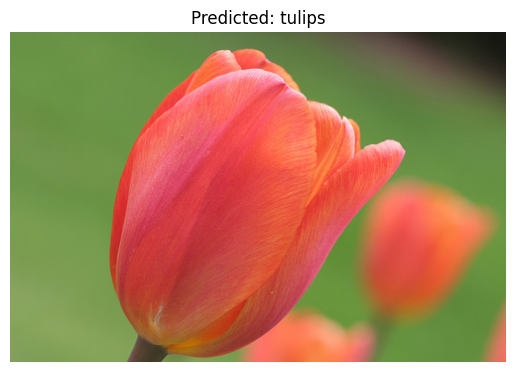

In [13]:
from PIL import Image

# Function to load the model
def load_model(model_path, num_classes):
    model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Function to predict the class of a single image
def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Path to the image you want to test
test_image_path = './test_image.jpg'  # Replace with actual path

# Load the model and run prediction
model = load_model(model_path, num_classes)
predict_image(test_image_path, model, transform, class_names)
